In this notebook, I will answer my first question : How listing attributes affect good ratings.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
listing_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv')
review_df = pd.read_csv('data/reviews.csv')

In [3]:
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

22.6% of the dataset does not have review_scores_rating as shown below

In [91]:
print('Percentage dataset with missing rating : {}%'.format(100*len(listing_df[listing_df.review_scores_rating.isna()])/len(listing_df)))

Percentage dataset with missing rating : 22.677824267782427%


In [126]:
new_listing_df = listing_df.dropna(subset=['review_scores_rating'])

The ratings is left skewed. So most of the listing have high ratings.

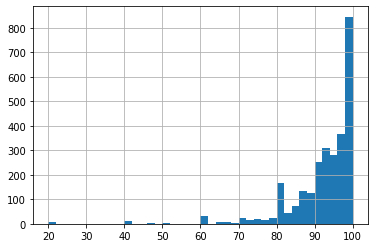

In [127]:
new_listing_df.review_scores_rating.hist(bins=40)

We can see number of listings per neighbourhood from below chart

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


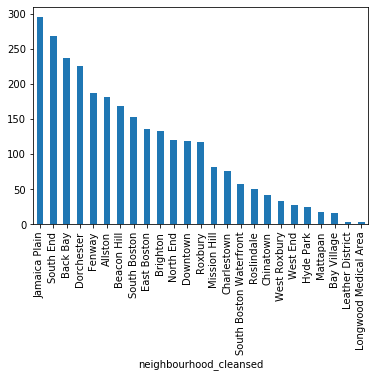

In [128]:
new_listing_df.groupby(['neighbourhood_cleansed']).id.count().sort_values(ascending=False).plot('bar')

Let's see what is the ratings on the neighbourhood with high amount of listings. I put 100 as a filter of high listings. 

In [129]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_rating.median().sort_values(ascending=False)

neighbourhood_cleansed
South Boston     96.0
Jamaica Plain    96.0
South End        95.0
North End        95.0
Beacon Hill      95.0
Downtown         94.0
Brighton         94.0
Allston          94.0
Fenway           93.0
Dorchester       93.0
Back Bay         93.0
East Boston      92.0
Roxbury          91.0
Name: review_scores_rating, dtype: float64

It does not showing much different. All the neighbourhood is having >90 ratings. Let's see what about other scores

In [130]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_communication.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
South Boston     10.0
Roxbury          10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
East Boston      10.0
Downtown         10.0
Dorchester       10.0
Brighton         10.0
Beacon Hill      10.0
Back Bay         10.0
Allston          10.0
Name: review_scores_communication, dtype: float64

In [131]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_location.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
Downtown         10.0
Beacon Hill      10.0
Back Bay         10.0
South Boston      9.0
East Boston       9.0
Dorchester        9.0
Brighton          9.0
Allston           9.0
Roxbury           8.0
Name: review_scores_location, dtype: float64

In [132]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_value.median().sort_values(ascending=False)

neighbourhood_cleansed
South Boston     10.0
Jamaica Plain    10.0
South End         9.0
Roxbury           9.0
North End         9.0
Fenway            9.0
East Boston       9.0
Downtown          9.0
Dorchester        9.0
Brighton          9.0
Beacon Hill       9.0
Back Bay          9.0
Allston           9.0
Name: review_scores_value, dtype: float64

In [133]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_checkin.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
South Boston     10.0
Roxbury          10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
East Boston      10.0
Downtown         10.0
Dorchester       10.0
Brighton         10.0
Beacon Hill      10.0
Back Bay         10.0
Allston          10.0
Name: review_scores_checkin, dtype: float64

It is interesting that the scores is not so much different. However on the location and rating scores we can see 'Roxbury' is having the lowest median value. Does it mean location scores highly corelate with ratings? Let's check below

In [135]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(new_listing_df.select_dtypes(include=numerics).corr().review_scores_rating.sort_values(ascending=False))


review_scores_rating              1.000000e+00
review_scores_value               7.863196e-01
review_scores_cleanliness         7.543265e-01
review_scores_accuracy            7.051036e-01
review_scores_communication       6.005987e-01
review_scores_checkin             5.840339e-01
review_scores_location            4.589012e-01
reviews_per_month                 7.697572e-02
bedrooms                          5.527182e-02
guests_included                   4.740234e-02
accommodates                      3.665309e-02
beds                              3.385165e-02
id                                3.187731e-02
number_of_reviews                 2.277785e-02
longitude                         1.774837e-02
host_id                           7.021828e-03
bathrooms                         2.121631e-03
maximum_nights                    1.544777e-04
scrape_id                         1.419066e-15
latitude                         -1.451130e-02
minimum_nights                   -2.908177e-02
availability_

In [137]:
new_listing_df.space

1       Small but cozy and quite room with a full size...
2       Come stay with a friendly, middle-aged guy in ...
3       Most places you find in Boston are small howev...
4       Clean, attractive, private room, one block fro...
5       Our sunny condo is located on the second and t...
                              ...                        
3574                                                  NaN
3575                                                  NaN
3578    Very safe, bustling with shops, restaurants, H...
3580                                                  NaN
3583                                                  NaN
Name: space, Length: 2772, dtype: object